In [2]:
from __future__ import print_function, division
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io, transform
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.optim import Adam

# use gpu or not
if torch.cuda.is_available():
    device = 'cuda'
    print('using gpu')
else:
    device = 'cpu'
    
device = torch.device(device)


if not os.path.exists('ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

using gpu


In [9]:

IMG_SHAPE = (224, 224)

import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
    img_filenames.append(os.path.join(root_dir, filename.attrib['file']).replace('\\', '/'))
    box = filename[0].attrib
    # x, y for the top left corner of the box, w, h for box width and height
    bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

    landmark = []
    for num in range(68):
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
    landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 


class FaceDataset(Dataset):

    def __init__(self, img_filenames, landmarks, bboxes, transform=None, flag = "train"):
        self.transform = transform
        self.all_x = img_filenames
        self.all_y = landmarks
        self.all_b = bboxes
        length = int(0.8 * len(self.all_y))
        if flag=="train":
            self.all_x = self.all_x[0:length]
            self.all_y = self.all_y[0:length]
            self.all_b = self.all_b[0:length]
        elif flag=="val":
            self.all_x = self.all_x[length:len(self.all_x)]
            self.all_y = self.all_y[length:len(self.all_y)]
            self.all_b = self.all_b[length:len(self.all_b)]

    def __len__(self):
        return len(self.all_y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = io.imread(self.all_x[idx])
        marks = self.all_y[idx]
        box = self.all_b[idx]
        sample = {'image': image, 'marks': marks, 'box': box}

        if self.transform:
            sample = self.transform(sample)

        return sample

class CropBox(object):
    def __call__(self, sample):
        image, marks, box = sample['image'], sample['marks'], sample['box']
        h, w = image.shape[:2]
        x, y, wb, hb = box
        x, y, wb, hb = int(x), int(y), int(wb), int(hb)
#         print(h, w)
#         print(y, x, wb, hb)
        if y < 0:
            y = -y
        if x < 0:
            x = -x
        image = image[y: y + hb, x: x + wb]
        marks = marks - [x, y]
#         print(h, w)
#         print(hb, wb)
        return {'image': image, 'marks': marks}
    
class Rescale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        h, w = image.shape[:2]
        new_w, new_h = int(w*self.scale), int(h*self.scale)
        image = transform.resize(image, (new_h, new_w))
        marks = marks * self.scale
        return {'image': image, 'marks': marks}

class Rescale_length(object):
    def __init__(self, size):
        self.output_size = size

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        h, w = image.shape[:2]
#         print(h, w)
        new_h = self.output_size
        new_w = self.output_size
        image = transform.resize(image, (new_h, new_w))
        marks = marks * [new_w / w, new_h / h]
        return {'image': image, 'marks': marks}    

class RandomCrop(object):
    def __init__(self, output):
            self.output_size = output

    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        h, w = image.shape[:2]
        new_w = self.output_size
        new_h = self.output_size
        left = np.random.randint(0, w - new_w)
        top = np.random.randint(0, h - new_h)
        image = image[top: top + new_h, left: left + new_w]
        marks = marks - [left, top]
        return {'image': image, 'marks': marks}

# wait for update
class ToTensor(object):
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
#         print(image.shape)
#         if image.shape == (224, 224):
#             image = torch.stack((image, image, image), 2)
        if image.shape == (224, 224):
            new_img = []
            for i in image:
                img = []
                for j in i:
                    img.append([j ,j ,j])
                new_img.append(img)
            image = np.array(new_img)
#         print(image.shape)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'marks': torch.from_numpy(marks)}
    
class myColorJitter(object):
    def __init__(self, brightness=0):
        self.brightness = [1-brightness, 1+brightness]
        
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        bf = torch.tensor(1.0).uniform_(self.brightness[0], self.brightness[1]).item()
        image = transforms.functional.adjust_brightness(image, bf)
        image = transforms.functional.adjust_saturation(image, 2)
        return {'image': image, 'marks': marks}
    
class myFlip(object):
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        w, h = image.size
        image = transforms.functional.hflip(image)
        marks = marks * [-1, 1] + [w, 0]# [w - marks[0], h]
        return {'image': image, 'marks': marks}

class myRotation(object):
    def __init__(self, degree=0):
        self.degree = degree
        
    def __call__(self, sample):
        image, marks = sample['image'], sample['marks']
        w, h = image.size
        r_image = image.copy()
        r_image = r_image.rotate(self.degree, expand= False)
        angle = np.radians(self.degree)
        cos_ = np.cos(angle)
        sin_ = np.sin(angle)
        w = w/2
        h = h/2
        rotation = np.array([[cos_, -sin_], [sin_, cos_]])
        marks = marks - [w, h]
        marks = marks.dot(rotation)
        marks = marks + [w, h]
        return {'image': r_image, 'marks': marks}
    
transforms_ = transforms.Compose([
    CropBox(),
    Rescale_length(256),
    RandomCrop(224),
    ToTensor()])
# ToTensor()
# transforms_ = transforms.Compose([
#     myColorJitter(0.5),
#     myRotation(20),
#     myFlip(),
#     PIL2Array(),
#     ToTensor()])

transforms_test = transforms.Compose([
    CropBox(), 
    Rescale_length(224), 
    ToTensor()])

face_dataset_train = FaceDataset(img_filenames, landmarks, bboxes, transform=transforms_, flag = "train")
face_dataset_val = FaceDataset(img_filenames, landmarks, bboxes, transform=transforms_test, flag = "val")

# for i in range(len(face_dataset_train)):
#     sample = face_dataset_train[i]
#     image = sample['image']
#     marks = sample['marks']
#     print(i, image.shape, marks.shape)
#     plt.figure()
#     plt.imshow(image)
#     plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
#     plt.pause(0.001)  
#     plt.show()
#     if i == 4:
#         plt.show()
#         break

batch_size = 16
dataloader_train = DataLoader(face_dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = DataLoader(face_dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

# for i_batch, sample_batched in enumerate(dataloader_train):
#     print(i_batch, sample_batched['image'].size(),
#           sample_batched['marks'].size())
    
# for i_batch, sample_batched in enumerate(dataloader_val):
#     print(i_batch, sample_batched['image'].size(),
#           sample_batched['marks'].size())


Using cache found in C:\Users\Xin/.cache\torch\hub\pytorch_vision_v0.6.0


myNet(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

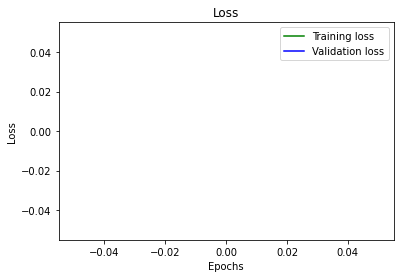

In [6]:
import torchvision.models as models
import torch

# we use transfer learning to save our training time


class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        self.resnet18.fc =  nn.Linear(512, 136)
        
    def forward(self, x):
        return self.resnet18(x)

cnn = myNet()
print(cnn)
cnn.to(device)

loss_fn = nn.MSELoss()
optimizer = Adam(cnn.parameters(), lr=0.001)

def getAccuracy(y1, y2):
    acc = 0.0
    y1 = y1.cpu().detach().numpy()
    y2 = y2.cpu().detach().numpy()
    for i in range(len(y1)):
        area1 = min(y1[i][0], y2[i][0])*min(y1[i][1], y2[i][1])
        area2 = max(y1[i][0], y2[i][0])*max(y1[i][1], y2[i][1])
        acc = acc + area1/area2
    return acc/(len(y1))
        
train_loss = []
train_acc = []
val_loss = []
val_acc= []

epochs = range(1, 1)

for i in epochs:
    print("enter the "+str(i)+" epoch")
    epoch_loss = []
    epoch_acc = []
    for i_batch, sample_batched in enumerate(dataloader_train):
#         image = sample_batched['image'][0]
#         marks = sample_batched['marks'][0]
#         print(i, image.shape, marks.shape)
#         plt.figure()
#         plt.imshow(image.reshape(IMG_SHAPE[1],IMG_SHAPE[0]), cmap='gray')
#         marks = marks.reshape(58, 2)
#         plt.scatter(marks[:, 0], marks[:, 1], s=10, marker='.', c='r')
#         plt.pause(0.001)  
#         plt.show()
#         exit()
        _size = len(sample_batched['image'])
#         print(_size)
#         exit()
        cnn.train()
        x_train = sample_batched['image'].float().to(device)
        y_train = sample_batched['marks'].float().to(device)
#         print(y_train.shape)
        y_train = y_train.reshape(_size, 136)
        outputs = cnn(x_train)
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        epoch_acc.append(getAccuracy(outputs, y_train))
    train_loss.append(sum(epoch_loss)/len(epoch_loss))
    train_acc.append(sum(epoch_acc)/len(epoch_acc))
    
    
    epoch_loss = []
    epoch_acc = []
    for i_batch, sample_batched in enumerate(dataloader_val):
        cnn.eval()
        x_val = sample_batched['image'].float().to(device)
        y_val = sample_batched['marks'].float().to(device)
        outputs = cnn(x_val)
        y_val = y_val.reshape(_size, 136)
        loss = loss_fn(outputs, y_val)
        prediction = outputs.cpu().data.numpy()
        epoch_loss.append(loss.item())
        epoch_acc.append(getAccuracy(outputs, y_val))
    val_loss.append(sum(epoch_loss)/len(epoch_loss))
    val_acc.append(sum(epoch_acc)/len(epoch_acc))
    
print(train_acc)
print(val_acc)

# task 1.2: Plot the train and validation accuracy during the training process.
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:

import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
    img_filenames.append(os.path.join(root_dir, filename.attrib['file']).replace('\\', '/'))
    box = filename[0].attrib
    # x, y for the top left corner of the box, w, h for box width and height
    bboxes.append([box['left'], box['top'], box['width'], box['height']]) 
    # landmark = []
    # for num in range(68):
    # 	x_coordinate = int(filename[0][num].attrib['x'])
    # 	y_coordinate = int(filename[0][num].attrib['y'])
    # 	landmark.append([x_coordinate, y_coordinate])
    # landmarks.append(landmark)

# landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

result = []
for i in range(len(bboxes)):
    image = io.imread(img_filenames[i])
  # crop
    h, w = image.shape[:2]
    x, y, wb, hb = bboxes[i]
    x, y, wb, hb = int(x), int(y), int(wb), int(hb)
    if y < 0:
        y = -y
    if x < 0:
        x = -x
    print(h, w)
    print(x, y, wb, hb)
    image = image[y: y + hb, x: x + wb]
  # update1.append([x, y])
    image = transform.resize(image, (224, 224))
  # update2.append([224/wb, 224/hb])
    if image.shape == (224, 224):
        new_img = []
        for i in image:
            img = []
            for j in i:
                img.append([j ,j ,j])
        new_img.append(img)
        image = np.array(new_img)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    output = cnn.train(image.to(device))
    
    

790 640
70 224 295 295
1024 1400
491 475 151 150
372 372
133 64 125 125
1214 960
279 328 446 447
1218 1294
427 328 447 447
850 744
228 228 310 310
812 1064
356 273 373 373
1837 2760
1565 749 180 180
2498 3031
940 940 1110 1110
3264 2448
1605 1685 180 180
600 501
161 133 259 259
893 931
273 232 373 373
2475 2512
680 886 926 925
400 350
22 9 126 125
1676 1676
572 513 536 536
800 546
68 229 496 447
1426 1311
503 420 485 487
681 819
378 31 447 447
225 620
175 36 125 126
251 559
238 76 104 105
1216 1217
427 328 447 447
1536 2048
620 391 259 259
349 399
122 75 114 118
917 916
273 232 373 373
768 618
391 450 180 181
541 480
63 110 216 216
2176 3264
1310 570 1110 1110
2592 3872
2426 993 259 259
1203 800
382 147 125 125
2337 3259
1063 693 1110 1111
480 640
180 68 446 496
462 699
27 152 200 180
615 410
110 110 150 150
853 1001
277 161 333 323
1172 1299
427 279 447 446
402 300
77 110 150 150
960 1280
394 215 536 536
524 600
90 56 311 310
1024 768
156 156 536 536
1828 1920
567 396 771 771
597 448


300 400
77 60 150 150
856 981
283 303 355 354
2048 3072
1063 570 1110 1110
1705 1463
275 513 536 536
1200 797
229 279 447 446
870 911
297 262 310 311
1592 1659
513 394 536 536
512 357
92 152 180 180
1065 800
159 193 311 311
2592 2945
693 693 1111 1111
1048 1047
356 315 373 372
859 969
397 273 373 373
685 928
331 193 311 311
1093 1093
356 315 373 372
1280 960
180 393 552 560
480 360
87 110 216 216
1685 2517
1018 325 216 216
879 930
248 228 305 300
860 580
423 175 126 125
2942 2591
940 817 1110 1110
440 440
112 132 180 180
1640 2100
544 149 198 193
640 562
90 228 311 310
1196 1032
191 356 372 373
2048 3072
1063 570 1110 1110
500 320
92 172 180 180
2048 3072
1063 693 1110 1111
540 720
278 110 216 216
1080 1920
1168 92 383 389
1713 1931
687 401 642 643
1207 948
180 328 446 447
500 365
87 134 216 216
1997 1997
615 615 643 643
1891 1256
809 908 180 180
1638 1092
259 401 643 643
2048 2759
768 713 943 942
362 432
143 110 150 150
1716 2261
535 416 1054 1041
761 783
125 159 310 311
1522 1618
513

1220 1219
490 356 373 373
1006 988
114 279 447 446
300 420
70 87 216 216
1067 1067
380 273 372 373
1738 1819
823 225 771 771
682 998
352 191 373 372
3264 2448
206 1176 1599 1598
1657 2440
1446 419 259 259
360 480
148 92 180 180
1200 1272
547 328 446 447
360 480
139 105 125 126
768 1024
417 193 310 311
400 316
84 92 180 180
540 390
64 206 216 216
3297 3675
1363 684 1332 1332
1099 1172
463 283 370 369
372 372
120 132 180 180
3040 2014
155 435 1926 1904
1024 1076
408 251 399 385
530 800
210 109 73 73
1024 768
62 116 643 643
903 903
296 262 310 311
1776 2584
415 563 259 259
1016 1016
329 273 372 373
1024 952
82 325 547 545
2274 885
296 134 216 216
2951 2336
730 886 926 925
331 500
256 110 151 150
1154 1200
264 68 514 495
917 917
344 297 311 310
411 531
165 56 310 310
863 1026
339 232 372 373
1103 1102
373 356 373 373
600 900
389 172 180 180
1012 1012
283 273 373 373
933 855
30 31 447 447
819 1050
321 67 373 373
856 839
232 228 310 310
677 1024
461 175 126 125
822 1200
235 228 70 72
969 969

2336 2263
349 578 925 925
300 450
119 122 105 105
1768 1768
581 473 643 643
788 702
277 199 261 255
315 425
267 65 105 104
